# Hydrological modeling (Lumped)

Raviraj Dave and August Posch, May 2025

This code uses historical time series of precipitation, potential evapotranspiration (PET), and streamflow/runoff/discharge, to calibrate and validate a model that uses daily precipitation and PET to predict daily discharge.

The hydrological model is a SIMHYD model.

Current version is for the Charles River catchment.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import random
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
#from pyswarm import pso
import os
os.environ['PYTHONHASHSEED'] = str(42)
from functools import partial
#Setting the seed for random number generators (random number gerneratin is deterministic)
seed = 42
np.random.seed(seed)
random.seed(seed)

In [3]:
#Input data (Comprising of daily precipitation, Evapotranspirationa and streamflow in mm)
data=pd.read_csv('../data/input_data_charles.csv')


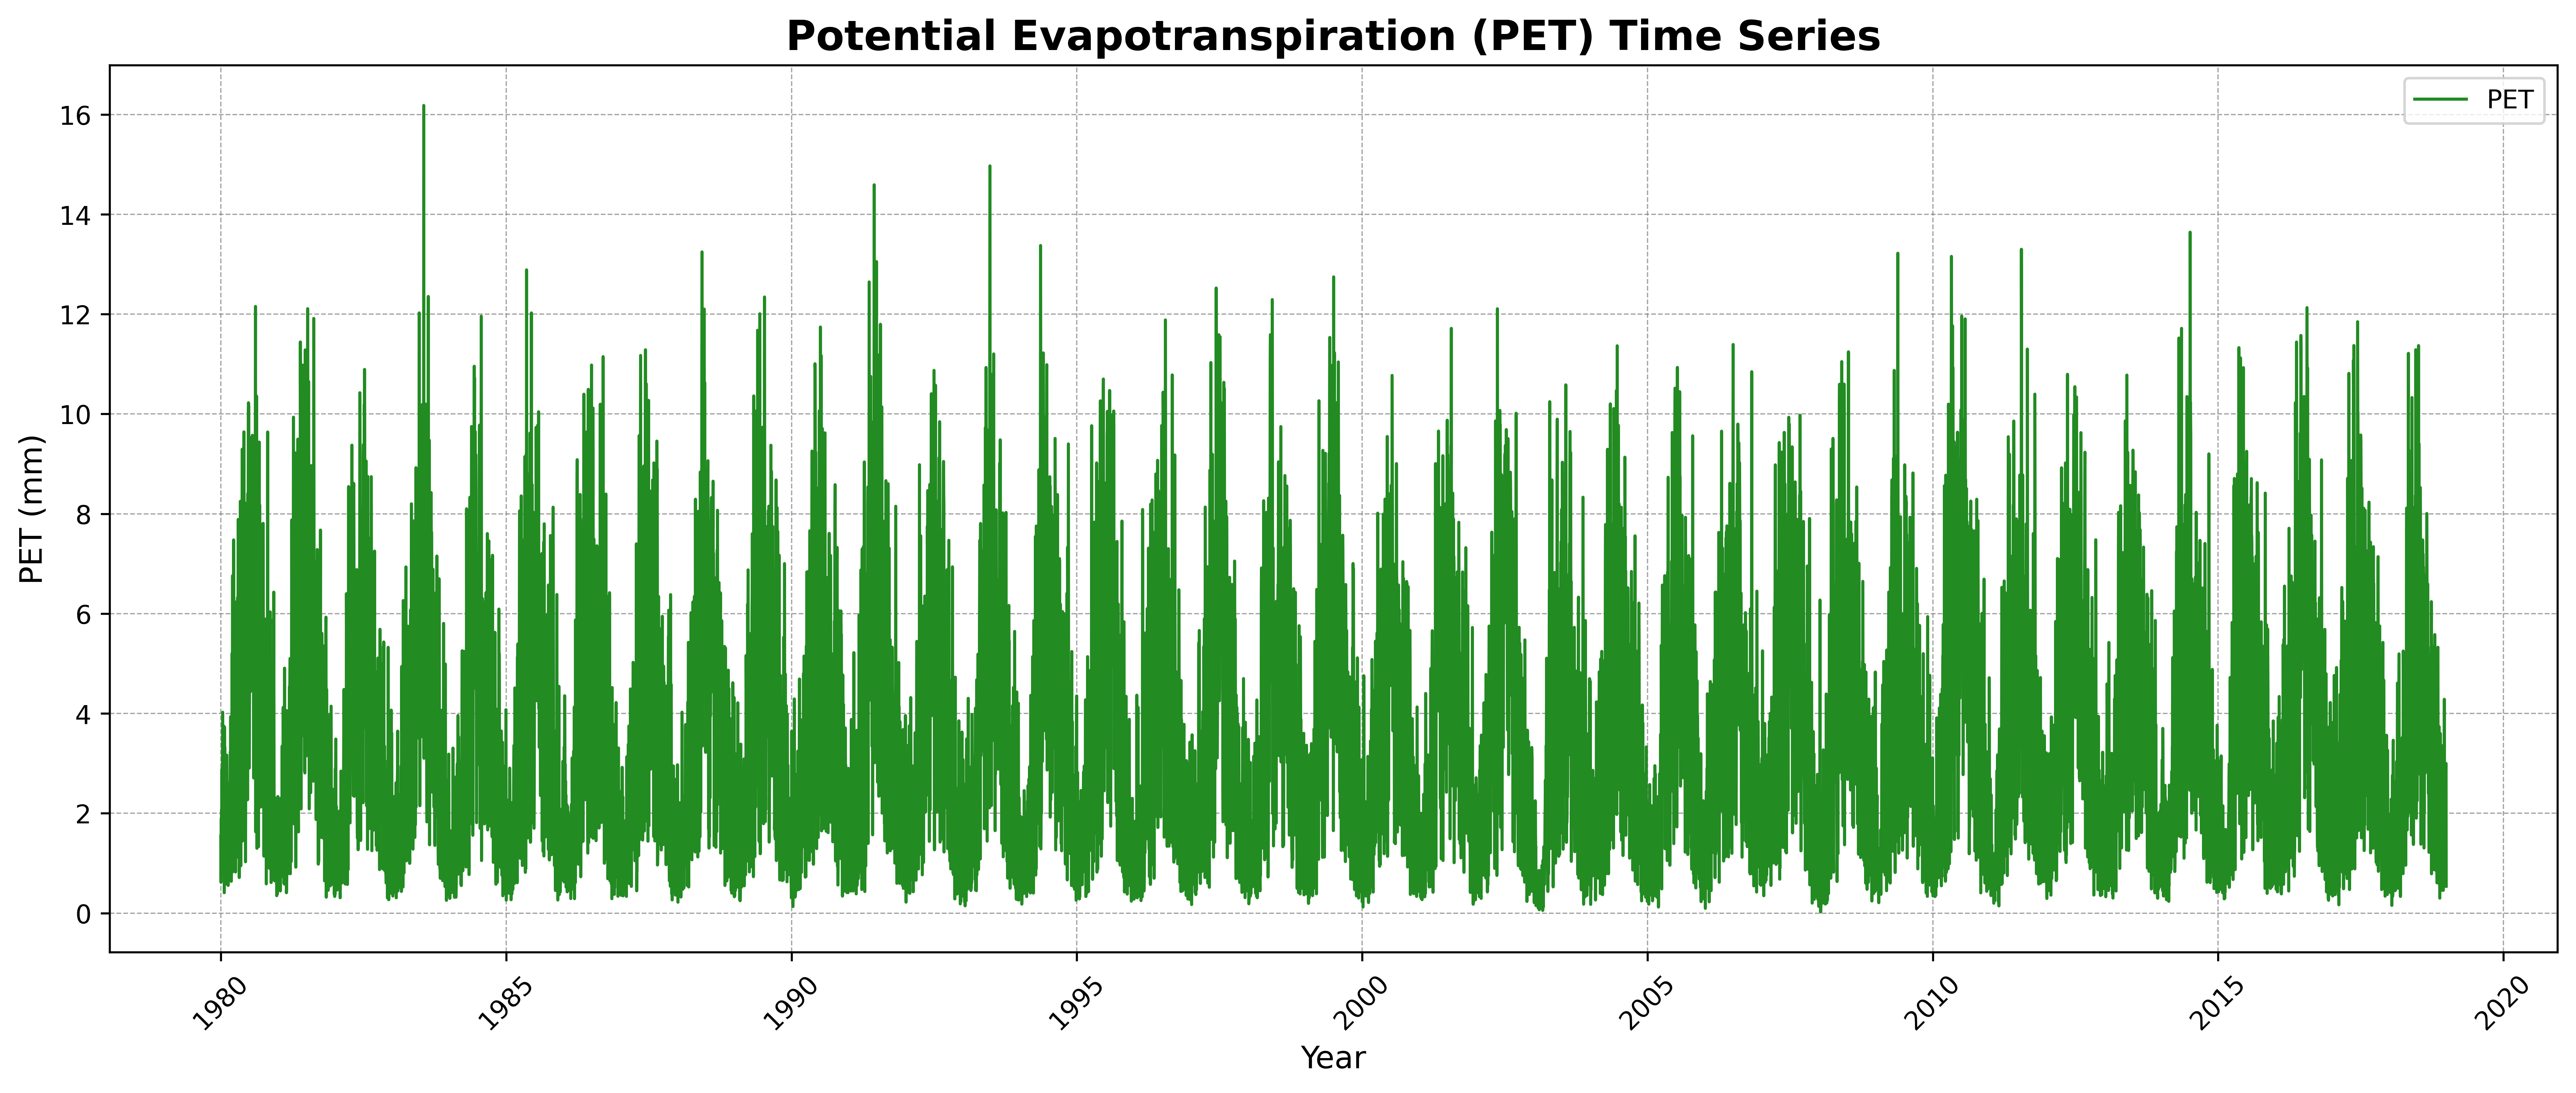

In [4]:
#PET Data plot
# Convert 'Date' with day-first format
data['Date'] = pd.to_datetime(data['Date'])

# Plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=600)
ax.plot(data['Date'], data['PET'], color='forestgreen', linewidth=1.2, label='PET')

# x-axis: 5-year interval
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=10)
ax.set_title("Potential Evapotranspiration (PET) Time Series", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("PET (mm)", fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('../figures/PET_Time_Series_charles.png', dpi=600, bbox_inches='tight')
plt.show()


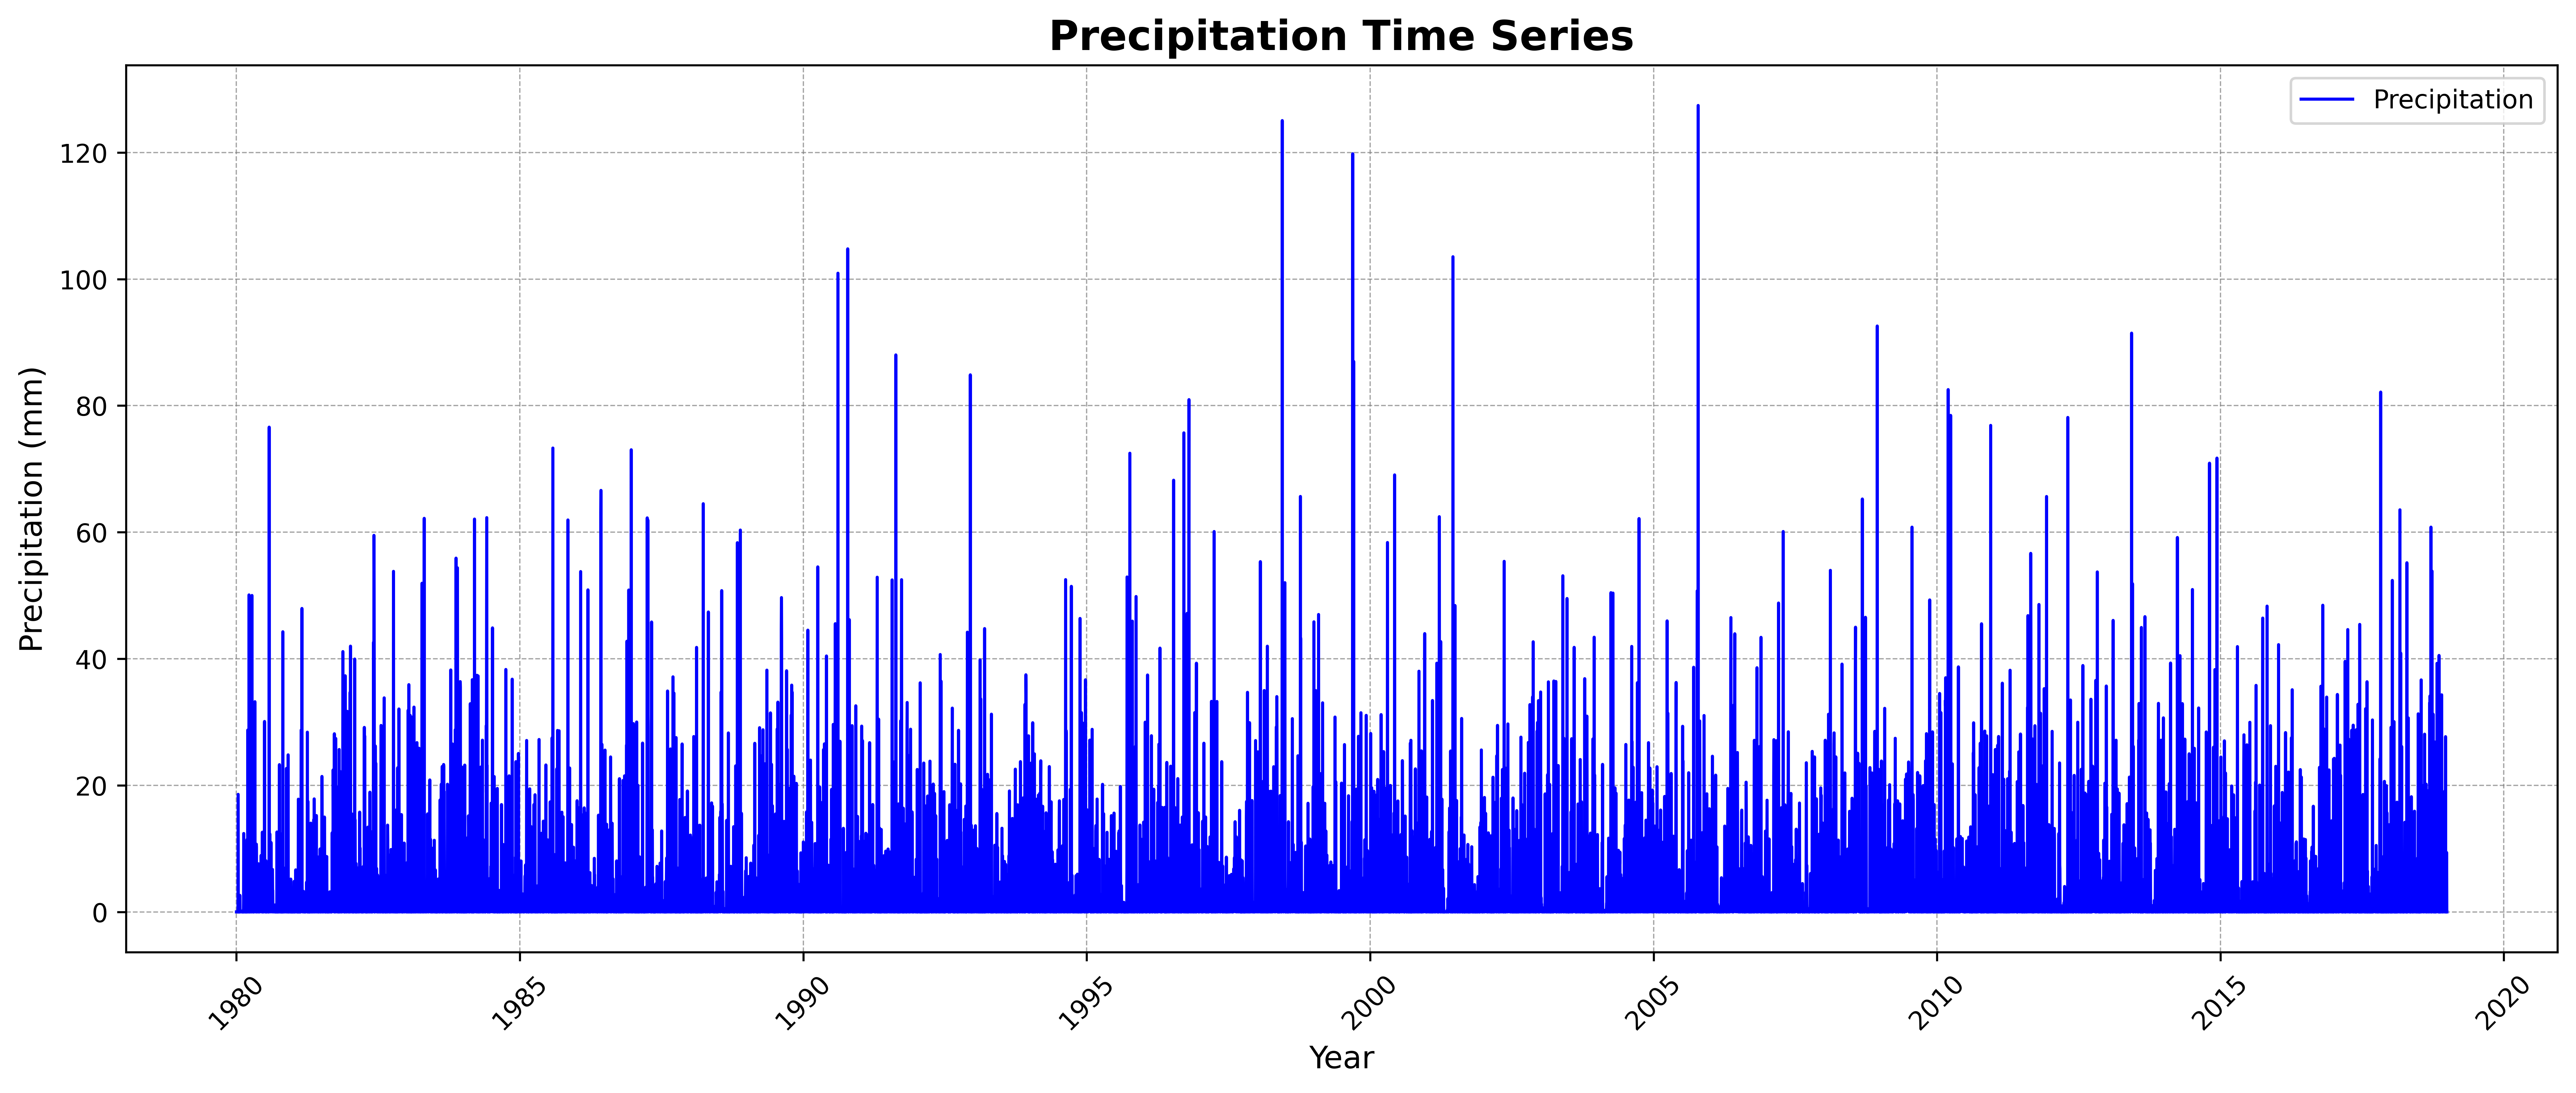

In [5]:
# Precipitation data plot

fig, ax = plt.subplots(figsize=(14, 6), dpi=600)
ax.plot(data['Date'], data['Pptn'], color='Blue', linewidth=1.2, label='Precipitation')

# Beautify x-axis: 5-year interval
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=10)

# Improve style
ax.set_title("Precipitation Time Series", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Precipitation (mm)", fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/Precipitation_Time_Series_charles.png', dpi=600, bbox_inches='tight')
plt.show()


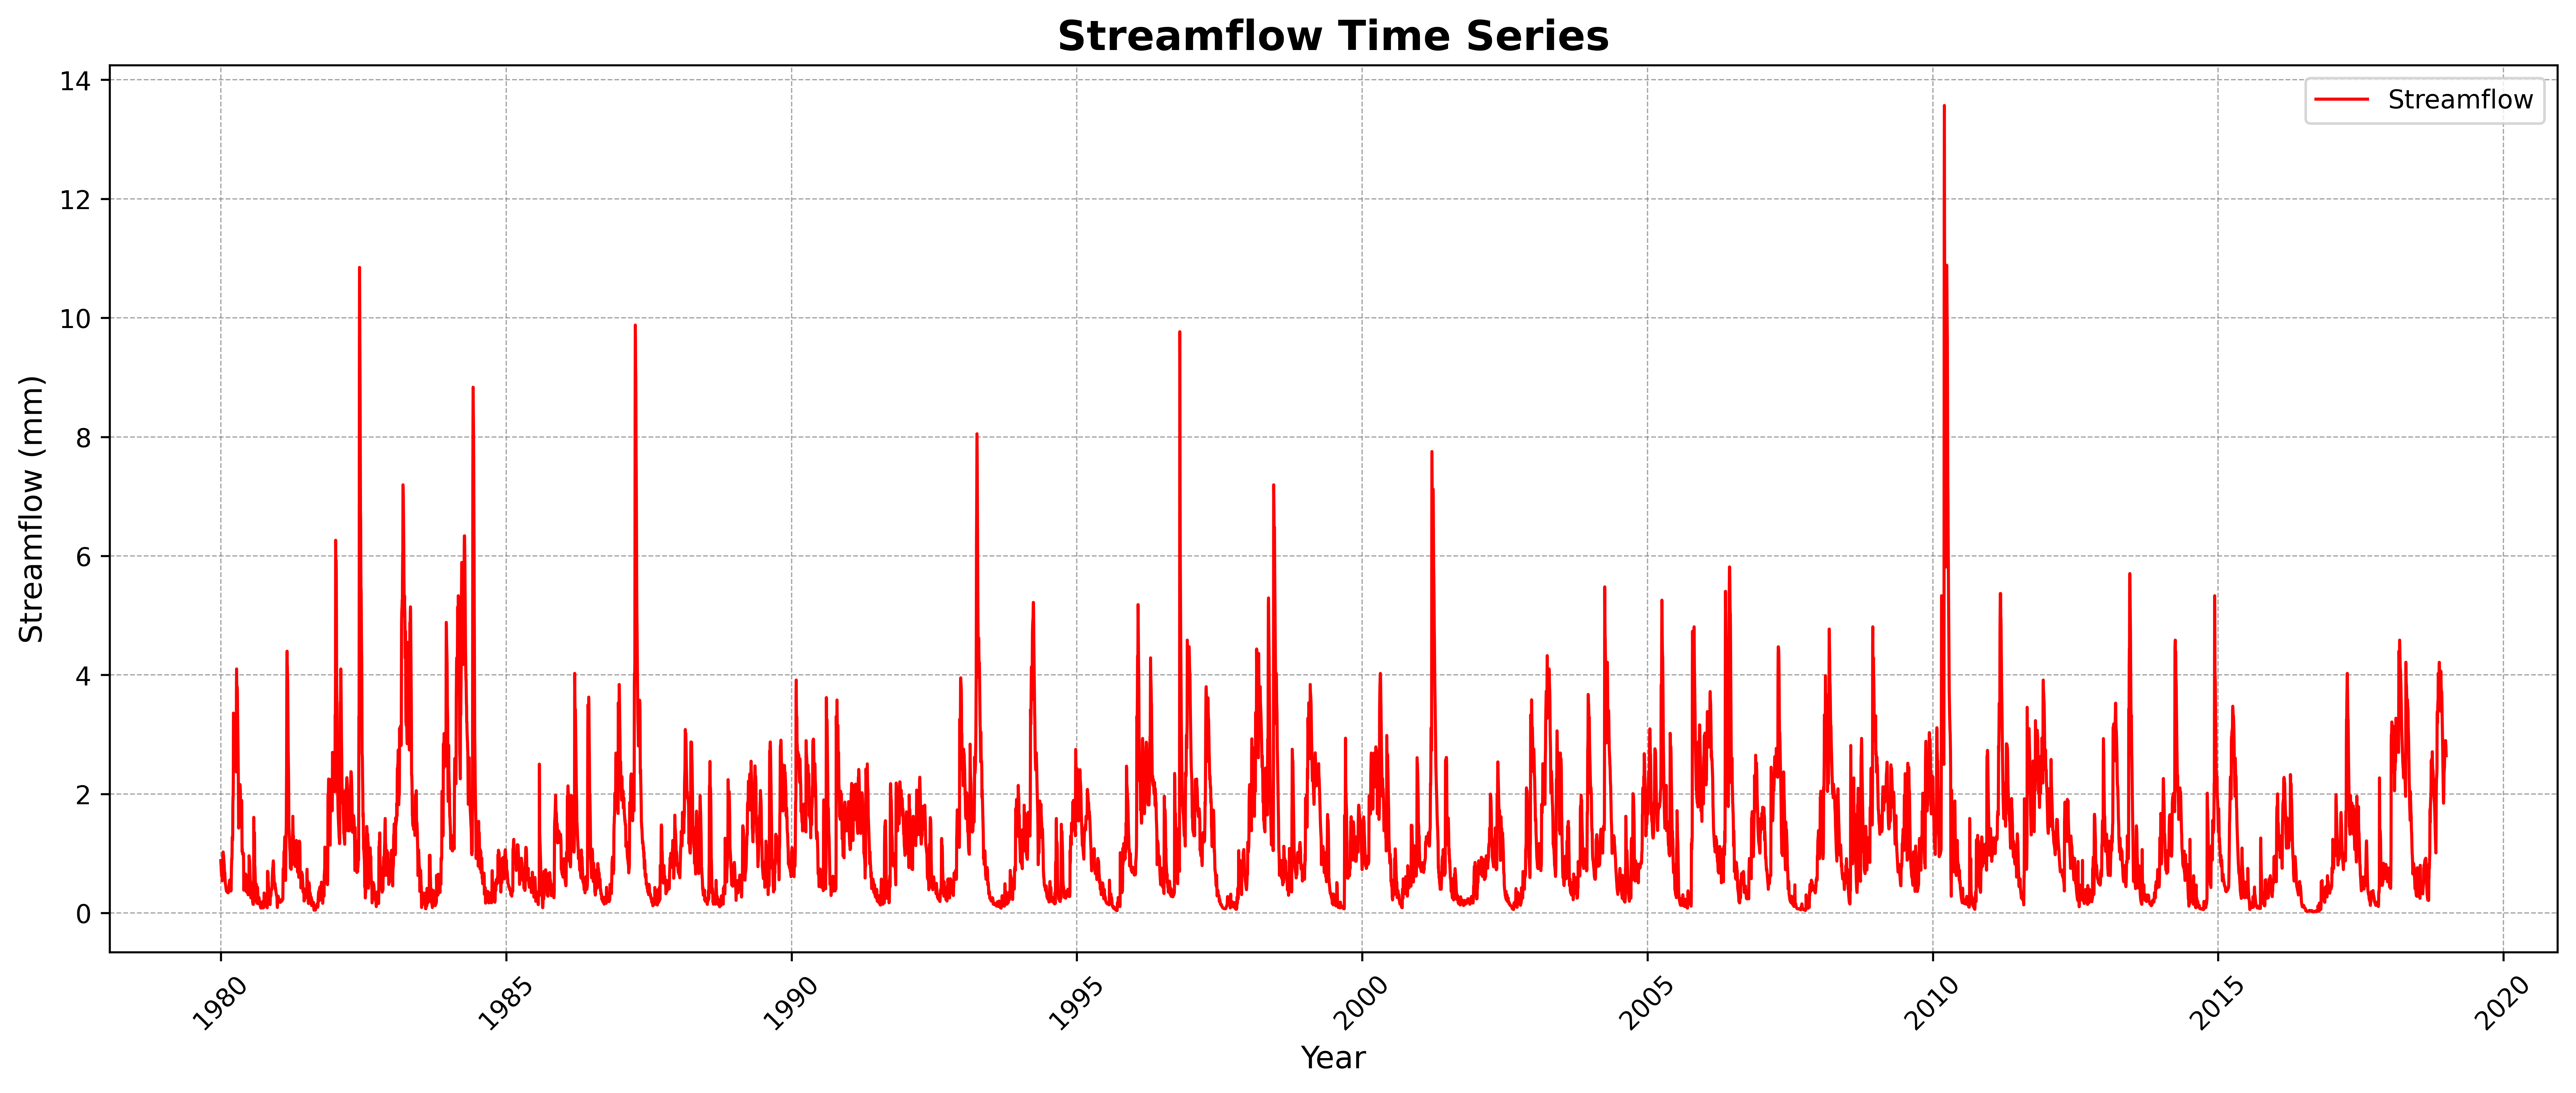

In [6]:
#Plot streamflow data


fig, ax = plt.subplots(figsize=(14, 6), dpi=600)
ax.plot(data['Date'], data['streamflow_mm'], color='Red', linewidth=1.2, label='Streamflow')

# Beautify x-axis: 5-year interval
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=10)

# Improve style
ax.set_title("Streamflow Time Series", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Streamflow (mm)", fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/Streamflow_Time_Series_charles.png', dpi=600, bbox_inches='tight')
plt.show()


# SIMHYD Model

## <li> Input data for calibration

In [7]:
# ----------------------------------------
# 1. Define key calibration simulation dates
# ----------------------------------------

warm_up_start = "1980-01-01"
warm_up_end   = "1980-12-31"

cal_start     = "1981-01-01"
cal_end       = "2000-12-31"

data=data.copy()

# ----------------------------------------
# 2. Filter full period (warm-up + calibration)
# ----------------------------------------

df_cal = data[(data['Date'] >= warm_up_start) & (data['Date'] <= cal_end)].set_index("Date").copy()

# ----------------------------------------
# 3. Mark the warm-up and calibration subsets
# ----------------------------------------

df_cal["phase"] = "calibration"
df_cal.loc[warm_up_start:warm_up_end, "phase"] = "warm-up"
warmup_period_length = 365


# ----------------------------------------
# 4. Parameter bounds
# ----------------------------------------

lb = [  0.5,   50, 0.0, 50 , 0.0, 0.0, 0.003]  # INSC, COEFF, SQ, SMSC, SUB, CRAK, K
ub = [ 5, 400, 6.0, 500, 1.0, 1.0, 0.30]



## <li> Optimization functions

In [8]:

def _obj_wrapper(func, args, kwargs, x):
    return func(x, *args, **kwargs)

def _is_feasible_wrapper(func, x):
    return np.all(func(x)>=0)

def _cons_none_wrapper(x):
    return np.array([0])

def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x):
    return np.array([y(x, *args, **kwargs) for y in ieqcons])

def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x):
    return np.array(f_ieqcons(x, *args, **kwargs))

def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={},
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100,
        minstep=1e-8, minfunc=1e-8, debug=False, processes=1,
        particle_output=False, seed=None):
    """
    Perform a particle swarm optimization (PSO)

    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)

    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified,
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
    processes : int
        The number of processes to use to evaluate objective function and
        constraints (default: 1)
    particle_output : boolean
        Whether to include the best per-particle position and the objective
        values at those.

    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    p : array
        The best known position per particle
    pf: arrray
        The objective values at each position in p

    """
    'set the seed for reproducibility'
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'

    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize objective function
    obj = partial(_obj_wrapper, func, args, kwargs)

    # Check for constraint function(s) #########################################
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = _cons_none_wrapper
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs)
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs)
    is_feasible = partial(_is_feasible_wrapper, cons)

    # Initialize the multiprocessing module if necessary
    if processes > 1:
        import multiprocessing
        mp_pool = multiprocessing.Pool(processes)

    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value

    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    if processes > 1:
        fx = np.array(mp_pool.map(obj, x))
        fs = np.array(mp_pool.map(is_feasible, x))
    else:
        for i in range(S):
            fx[i] = obj(x[i, :])
            fs[i] = is_feasible(x[i, :])

    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()

    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)

    # Iterate until termination criterion met ##################################
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        if processes > 1:
            fx = np.array(mp_pool.map(obj, x))
            fs = np.array(mp_pool.map(is_feasible, x))
        else:
            for i in range(S):
                fx[i] = obj(x[i, :])
                fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
        if fp[i_min] < fg:
            if debug:
                print('New best for swarm at iteration {:}: {:} {:}'\
                    .format(it, p[i_min, :], fp[i_min]))

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                print('Stopping search: Swarm best objective change less than {:}'\
                    .format(minfunc))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            elif stepsize <= minstep:
                print('Stopping search: Swarm best position change less than {:}'\
                    .format(minstep))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            else:
                g = p_min.copy()
                fg = fp[i_min]

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))

    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    if particle_output:
        return g, fg, p, fp
    else:
        return g, fg

## <li> Loss functions

In [9]:
def filter_nan(s,o):

    #this functions removed the data  from simulated and observed data
    #whereever the observed data contains nan

    #this is used by all other functions, otherwise they will produce nan as
    #output
    data = np.array([s.flatten(),o.flatten()])
    data = np.transpose(data)
    #data = data[~np.isnan(data).any(1)]
    return data[:,0],data[:,1]
def NS(s,o):

    #Nash Sutcliffe efficiency coefficient
    #input:
        #s: simulated
        #o: observed
    #output:
        #ns: Nash Sutcliffe efficient coefficient

    #s,o = filter_nan(s,o)
    return 1 - sum((s-o)**2)/sum((o-np.mean(o))**2)
def pc_bias(s,o):
    """
    Percent Bias
    input:
        s: simulated
        o: observed
    output:
        pc_bias: percent bias
    """
    #s,o = filter_nan(s,o)
    return 100.0*sum(o-s)/sum(o)
def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: simulated
        o: observed
    output:
        rmses: root mean squared error
    """
    #s,o = filter_nan(s,o)
    return np.sqrt(np.mean((s-o)**2))
def ve(s,o):
    #s,o = filter_nan(s,o)
    return 1 - abs(sum(o-s))/sum(o)
def mare(s,o):
    #s,o = filter_nan(s,o)
    return np.mean(sum((abs(o-s))/o))
def mae(s,o):
    #s,o = filter_nan(s,o)
    return abs(np.mean(sum(o-s)))
def corr_coeff(s,o):
    #s,o = filter_nan(s,o)
    return np.corrcoef(s,o)[0,1]
def kge(s,o):
    #s,o = filter_nan(s,o)
    alpha = np.std(s)/np.std(o)
    beta = np.mean(s)/np.mean(o)
    return 1-((1 - np.corrcoef(s,o)[0,1])**2 + (alpha - 1)**2 + (beta - 1)**2)**0.5

## <li> hydrological model equations

In [10]:
def loss_fun1(x):
    INSC = x[0]
    COEFF = x[1]
    SQ = x[2]
    SMSC = x[3]
    SUB = x[4]
    CRAK = x[5]
    K = x[6]
#     DELAY = x[7]
#     X_m = x[8]
    loss = []
    Prec = data['Pptn']
    Evap = data['PET']
# total runoff
    Q_cal = np.zeros(len(Prec))
    # interception store
    IMAX = np.zeros(len(Prec))
    # interception amount
    INT  = np.zeros(len(Prec))
    # interception runoff
    INR  = np.zeros(len(Prec))
    # infiltration capacity
    RMO  = np.zeros(len(Prec))
    # direct runoff
    IRUN = np.zeros(len(Prec))
    # Soil evaporation
    ET   = np.zeros(len(Prec))
    # Saturation excess runoff and interflow
    SRUN = np.zeros(len(Prec))
    # Recharge
    REC  = np.zeros(len(Prec))
    # Infiltration into soil store
    SMF  = np.zeros(len(Prec))
    # potential evapotranspiration (PET - interception)
    POT  = np.zeros(len(Prec))
    # baseflow
    BAS  = np.zeros(len(Prec))
    # soil moisture storage
    SMS  = np.zeros(len(Prec))
    # ground water storage
    GW   = np.zeros(len(Prec))
    U   = np.zeros(len(Prec))
    Q = np.zeros(len(Prec))
    data['ET_cal'] = np.zeros(len(Prec))
# baseflow for output
    data['SM_cal'] = np.zeros(len(Prec))
# baseflow for output
    data['GW_cal'] = np.zeros(len(Prec))
# baseflow for output
    data['GD_cal'] = np.zeros(len(Prec))
# surface runoff for output
    data['DR_cal'] = np.zeros(len(Prec))
    data['Q_cal'] = np.zeros(len(Prec))
    #INSC= 1.75130714e+01
# COEFF= 2.83039141e+02
# SQ= 2.24645451e-01
# SMSC= 8.23694469e+02
# SUB= 3.02338083e-01
# CRAK= 4.95380472e-01
# K= 5.33887466e-02
    GWt1, GWt0 = 0, 0
    SMSt0 = 0
    SMSt1 = SMSt0 * SMSC

    for t in range(len(Prec)):
        # calculate interception store
        IMAX[t] = min(INSC, Evap[t])
        # then calculate interception
        INT[t] = min(IMAX[t], Prec[t])
        # calculate runoff after interception
        INR[t] = Prec[t] - INT[t]
        # calculate infiltration capacity
        RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
        # calculate direct runoff after loading to infiltration capacity
        IRUN[t] = INR[t] - RMO[t]
        # saturation excess runoff and interflow
        SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
        # calculate recharge
        REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
        # calculate infiltration into soil store
        SMF[t] = RMO[t] - SRUN[t] - REC[t]
        # calculate potential ET (amount of Evap after loses)
        POT[t] = Evap[t] - INT[t]
        # calculate soil evaporation
        ET[t] = min(10 * SMSt1/SMSC, POT[t])
        # calculate soil moisture storage (SMS) overflow
        SMS[t] = SMSt1 + SMF[t] - ET[t]
        # update states of SMS, REC and SMSt1
        if SMS[t] > SMSC:
            REC[t] = REC[t] + SMS[t] - SMSC
            SMS[t] = SMSC
        SMSt1 = SMS[t]
        # calculate baseflow
        BAS[t] = K * GWt1
        # calculate ground water storage
        GW[t] = GWt1 + REC[t] - BAS[t]
        # update state of GWt1
        GWt1 = GW[t]
        # final runoff (effective precipitation) calculation
        DR_cal = IRUN[t] + SRUN[t]
        GD_cal = BAS[t]
        Q[t] = IRUN[t] + SRUN[t] + BAS[t]

        # initialize transformed runoff

        # calculate Muskinghum components
#         if (2*DELAY*X_m < 1) & (2*DELAY*(1-X_m) > 1):
#             C0 = (-DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
#             C1 = (DELAY*X_m+0.5)/(DELAY*(1-X_m)+0.5)
#             C2 = (DELAY*(1-X_m)-0.5)/(DELAY*(1-X_m)+0.5)
#         else:
#             C0 = 0
#             C1 = 1
#             C2 = 0
#         # check formal relations
#         if (C0 + C1 + C2) != 1.0:
#             C0 = 0
#             C1 = 1
#             C2 = 0
#             # start transformation
#         Q[-1] = U[-1]
#         Q[t] = C0 * U[t] + C1 * U[t-1] + C2 * Q[t-1]
#         if Q[t] < 0: Q[t] = 0



    loss=np.array(Q)
    #s_cal = s[1461:5844]
    #s_cal = s_cal.values
    tar=np.array(data.loc[:,'streamflow_mm'])
    tar=np.transpose(tar)
    loss = loss[warmup_period_length:]
    tar = tar[warmup_period_length:]
    return sum((loss-tar)**2)/sum((tar-np.mean(tar))**2)#((1 - (np.corrcoef(loss,tar))[0,1])**2 + (np.std(loss)/np.std(tar) - 1)**2 + (np.mean(loss)/np.mean(tar) - 1)**2)**0.5 ##


## <li> model calibration initialization for parameter tuning

In [11]:
# Ensure data is correctly passed to loss function
data = df_cal.copy()  # or whatever subset you are using

best_pars, best_obj = pso(
    func      = loss_fun1,
    lb        = lb,
    ub        = ub,
    swarmsize = 60,          # ← increase once everything works
    maxiter   = 80,
    omega     = 0.5,
    phip      = 0.7,
    phig      = 0.7,
    seed      = 42,
    debug     = True
)
cal_NSE = 1.0 - best_obj
print("\n=== OPTIMAL PARAMETERS ===")
for name, val in zip(['INSC','COEFF','SQ','SMSC','SUB','CRAK','K'], best_pars):
    print(f"{name:5s} : {val:8.3f}")
print(f"\nCalibration NSE : {cal_NSE:6.3f}")

No constraints given.
New best for swarm at iteration 1: [5.00000000e-01 3.24280685e+02 1.96151987e+00 3.78039096e+02
 1.86276106e-01 7.34589085e-01 2.36023290e-01] 0.6415726611629099
Best after iteration 1: [5.00000000e-01 3.24280685e+02 1.96151987e+00 3.78039096e+02
 1.86276106e-01 7.34589085e-01 2.36023290e-01] 0.6415726611629099
New best for swarm at iteration 2: [5.00000000e-01 3.50849516e+02 1.59694324e+00 4.76086220e+02
 1.15081886e-01 7.65624399e-01 2.40807317e-01] 0.593223057243401
Best after iteration 2: [5.00000000e-01 3.50849516e+02 1.59694324e+00 4.76086220e+02
 1.15081886e-01 7.65624399e-01 2.40807317e-01] 0.593223057243401
New best for swarm at iteration 3: [5.00000000e-01 2.20739221e+02 3.94346547e-02 4.00714914e+02
 8.58966026e-02 8.10417849e-01 1.48531512e-01] 0.3724497416835236
Best after iteration 3: [5.00000000e-01 2.20739221e+02 3.94346547e-02 4.00714914e+02
 8.58966026e-02 8.10417849e-01 1.48531512e-01] 0.3724497416835236
Best after iteration 4: [5.00000000e-01 2

In [12]:
#print parameters
print("\n=== OPTIMAL PARAMETERS ===")
for name, val in zip(['INSC','COEFF','SQ','SMSC','SUB','CRAK','K'], best_pars):
    print(f"{name:5s} : {val:8.3f}")
print(f"\nCalibration NSE : {cal_NSE:6.3f}")


=== OPTIMAL PARAMETERS ===
INSC  :    0.500
COEFF :  213.420
SQ    :    0.450
SMSC  :  299.102
SUB   :    0.071
CRAK  :    1.000
K     :    0.082

Calibration NSE :  0.728


Save down the best parameters

In [13]:
np.save('../calibrated_model_params/best_pars_charles.npy', best_pars)

## <li> Calibrated model results (calibration period)

In [14]:
loss = []
df_cal=data.loc[warm_up_start:cal_end]
Prec = df_cal['Pptn']
Evap = df_cal['PET']
Q_cal = np.zeros(len(Prec))
# interception store
IMAX = np.zeros(len(Prec))
# interception amount
INT  = np.zeros(len(Prec))
# interception runoff
INR  = np.zeros(len(Prec))
# infiltration capacity
RMO  = np.zeros(len(Prec))
# direct runoff
IRUN = np.zeros(len(Prec))
# Soil evaporation
ET   = np.zeros(len(Prec))
# Saturation excess runoff and interflow
SRUN = np.zeros(len(Prec))
# Recharge
REC  = np.zeros(len(Prec))
# Infiltration into soil store
SMF  = np.zeros(len(Prec))
# potential evapotranspiration (PET - interception)
POT  = np.zeros(len(Prec))
# baseflow
BAS  = np.zeros(len(Prec))
# soil moisture storage
SMS  = np.zeros(len(Prec))
# ground water storage
GW   = np.zeros(len(Prec))


Q = np.zeros(len(Prec))

df_cal['ET_cal'] = np.zeros(len(Prec))
# baseflow for output
df_cal['SM_cal'] = np.zeros(len(Prec))
# baseflow for output
df_cal['GW_cal'] = np.zeros(len(Prec))
# baseflow for output
df_cal['GD_cal'] = np.zeros(len(Prec))
# surface runoff for output
df_cal['DR_cal'] = np.zeros(len(Prec))
df_cal['Q_cal'] = np.zeros(len(Prec))
INSC= best_pars[0]  # fill in the best parameter values found from calibrations
COEFF= best_pars[1]
SQ= best_pars[2]
SMSC= best_pars[3]
SUB=best_pars[4]
CRAK= best_pars[5]
K= best_pars[6]
GWt1, GWt0 = 0, 0
SMSt0 = 0
SMSt1 = SMSt0 * SMSC

for t in range(len(Prec)):
    # calculate interception store
    IMAX[t] = min(INSC, Evap[t])
    # then calculate interception
    INT[t] = min(IMAX[t], Prec[t])
    # calculate runoff after interception
    INR[t] = Prec[t] - INT[t]
    # calculate infiltration capacity
    RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
    # calculate direct runoff after loading to infiltration capacity
    IRUN[t] = INR[t] - RMO[t]
    # saturation excess runoff and interflow
    SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
    # calculate recharge
    REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
    # calculate infiltration into soil store
    SMF[t] = RMO[t] - SRUN[t] - REC[t]
    # calculate potential ET (amount of Evap after loses)
    POT[t] = Evap[t] - INT[t]
    # calculate soil evaporation
    ET[t] = min(10 * SMSt1/SMSC, POT[t])
    # calculate soil moisture storage (SMS) overflow
    SMS[t] = SMSt1 + SMF[t] - ET[t]
    # update states of SMS, REC and SMSt1
    if SMS[t] > SMSC:
        REC[t] = REC[t] + SMS[t] - SMSC
        SMS[t] = SMSC
    SMSt1 = SMS[t]
    # calculate baseflow
    BAS[t] = K * GWt1
    # calculate ground water storage
    GW[t] = GWt1 + REC[t] - BAS[t]
    # update state of GWt1
    GWt1 = GW[t]
    # final runoff (effective precipitation) calculation
    DR_cal = IRUN[t] + SRUN[t]
    GD_cal = BAS[t]
    Q[t] = IRUN[t] + SRUN[t] + BAS[t]

    df_cal['ET_cal'][t] = INT[t] + ET[t]
    # baseflow for output
    df_cal['SM_cal'][t] = SMS[t]
    # baseflow for output
    df_cal['GW_cal'][t] = GW[t]
    # baseflow for output
    df_cal['GD_cal'][t] = BAS[t]
    # surface runoff for output
    df_cal['DR_cal'][t] = IRUN[t] + SRUN[t]
    df_cal['Q_cal'][t] = Q[t]

In [15]:
# calibration plot

# Plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=600)
ax.plot(df_cal.index, df_cal['streamflow_mm'], color='Red', linewidth=1.2, label='Observed Streamflow')
ax.plot(df_cal.index, df_cal['Q_cal'], color='blue', linewidth=1.2, label='Simulated Streamflow')

# Beautify x-axis: 5-year interval
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=10)

# Improve style
ax.set_title("Calibration Streamflow Time Series", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Streamflow (mm)", fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
#ax.spines[['top', 'right']].set_visible(False)  # Cleaner border
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/calibration_streamflow_Time_Series_charles.png', dpi=600, bbox_inches='tight')
plt.show()


## <li> Validation

In [18]:
data=pd.read_csv('../data/input_data_charles.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
# ----------------------------------------
# 1. Define key simulation dates
# ----------------------------------------

warm_up_val_start = "2001-01-01"
warm_up_val_end   = "2001-12-31"

val_start     = "2002-01-01"
val_end       = "2018-12-31"

# Optional: convert if needed
#data['Date'] = pd.to_datetime(data['Date'])

# ----------------------------------------
# 2. Filter full period (warm-up + calibration)
# ----------------------------------------

df_val = data[(data['Date'] >= warm_up_val_start) & (data['Date'] <= val_end)].set_index("Date").copy()

# ----------------------------------------
# 3. Mark the warm-up and calibration subsets (optional but helpful)
# ----------------------------------------

df_val["phase"] = "validation"
df_val.loc[warm_up_val_start:warm_up_val_end, "phase"] = "warm-up"
warmup_period_length = 365


In [20]:
loss = []
#df_val=data.loc[warm_up_val_start:val_end]
Prec = df_val['Pptn']
Evap = df_val['PET']
Q_val = np.zeros(len(Prec))
# interception store
IMAX = np.zeros(len(Prec))
# interception amount
INT  = np.zeros(len(Prec))
# interception runoff
INR  = np.zeros(len(Prec))
# infiltration capacity
RMO  = np.zeros(len(Prec))
# direct runoff
IRUN = np.zeros(len(Prec))
# Soil evaporation
ET   = np.zeros(len(Prec))
# Saturation excess runoff and interflow
SRUN = np.zeros(len(Prec))
# Recharge
REC  = np.zeros(len(Prec))
# Infiltration into soil store
SMF  = np.zeros(len(Prec))
# potential evapotranspiration (PET - interception)
POT  = np.zeros(len(Prec))
# baseflow
BAS  = np.zeros(len(Prec))
# soil moisture storage
SMS  = np.zeros(len(Prec))
# ground water storage
GW   = np.zeros(len(Prec))


Q = np.zeros(len(Prec))

df_val['ET_val'] = np.zeros(len(Prec))
# baseflow for output
df_val['SM_val'] = np.zeros(len(Prec))
# baseflow for output
df_val['GW_val'] = np.zeros(len(Prec))
# baseflow for output
df_val['GD_val'] = np.zeros(len(Prec))
# surface runoff for output
df_val['DR_val'] = np.zeros(len(Prec))
df_val['Q_val'] = np.zeros(len(Prec))
INSC= best_pars[0]  # fill in the best parameter values found from calibrations
COEFF= best_pars[1]
SQ= best_pars[2]
SMSC= best_pars[3]
SUB=best_pars[4]
CRAK= best_pars[5]
K= best_pars[6]
GWt1, GWt0 = 0, 0
SMSt0 = 0
SMSt1 = SMSt0 * SMSC

for t in range(len(Prec)):
    # calculate interception store
    IMAX[t] = min(INSC, Evap[t])
    # then calculate interception
    INT[t] = min(IMAX[t], Prec[t])
    # calculate runoff after interception
    INR[t] = Prec[t] - INT[t]
    # calculate infiltration capacity
    RMO[t] = min(COEFF*np.exp(-SQ*SMSt1/SMSC), INR[t])
    # calculate direct runoff after loading to infiltration capacity
    IRUN[t] = INR[t] - RMO[t]
    # saturation excess runoff and interflow
    SRUN[t] = SUB * SMSt1 / SMSC * RMO[t]
    # calculate recharge
    REC[t] = CRAK * SMSt1 / SMSC * (RMO[t] - SRUN[t])
    # calculate infiltration into soil store
    SMF[t] = RMO[t] - SRUN[t] - REC[t]
    # calculate potential ET (amount of Evap after loses)
    POT[t] = Evap[t] - INT[t]
    # calculate soil evaporation
    ET[t] = min(10 * SMSt1/SMSC, POT[t])
    # calculate soil moisture storage (SMS) overflow
    SMS[t] = SMSt1 + SMF[t] - ET[t]
    # update states of SMS, REC and SMSt1
    if SMS[t] > SMSC:
        REC[t] = REC[t] + SMS[t] - SMSC
        SMS[t] = SMSC
    SMSt1 = SMS[t]
    # calculate baseflow
    BAS[t] = K * GWt1
    # calculate ground water storage
    GW[t] = GWt1 + REC[t] - BAS[t]
    # update state of GWt1
    GWt1 = GW[t]
    # final runoff (effective precipitation) calculation
    DR_val = IRUN[t] + SRUN[t]
    GD_val = BAS[t]
    Q[t] = IRUN[t] + SRUN[t] + BAS[t]

    df_val['ET_val'][t] = INT[t] + ET[t]
    # baseflow for output
    df_val['SM_val'][t] = SMS[t]
    # baseflow for output
    df_val['GW_val'][t] = GW[t]
    # baseflow for output
    df_val['GD_val'][t] = BAS[t]
    # surface runoff for output
    df_val['DR_val'][t] = IRUN[t] + SRUN[t]
    df_val['Q_val'][t] = Q[t]

In [21]:
def nse(observed, simulated):
    observed = np.array(observed)
    simulated = np.array(simulated)

    # Ensure equal lengths
    if len(observed) != len(simulated):
        raise ValueError("Observed and simulated arrays must have the same length.")

    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)

    return 1 - (numerator / denominator)
obs=df_val['streamflow_mm']
sim=df_val['Q_val']
nse_value = nse(obs, sim)
print(f"NSE: {nse_value:.4f}")

NSE: 0.7035


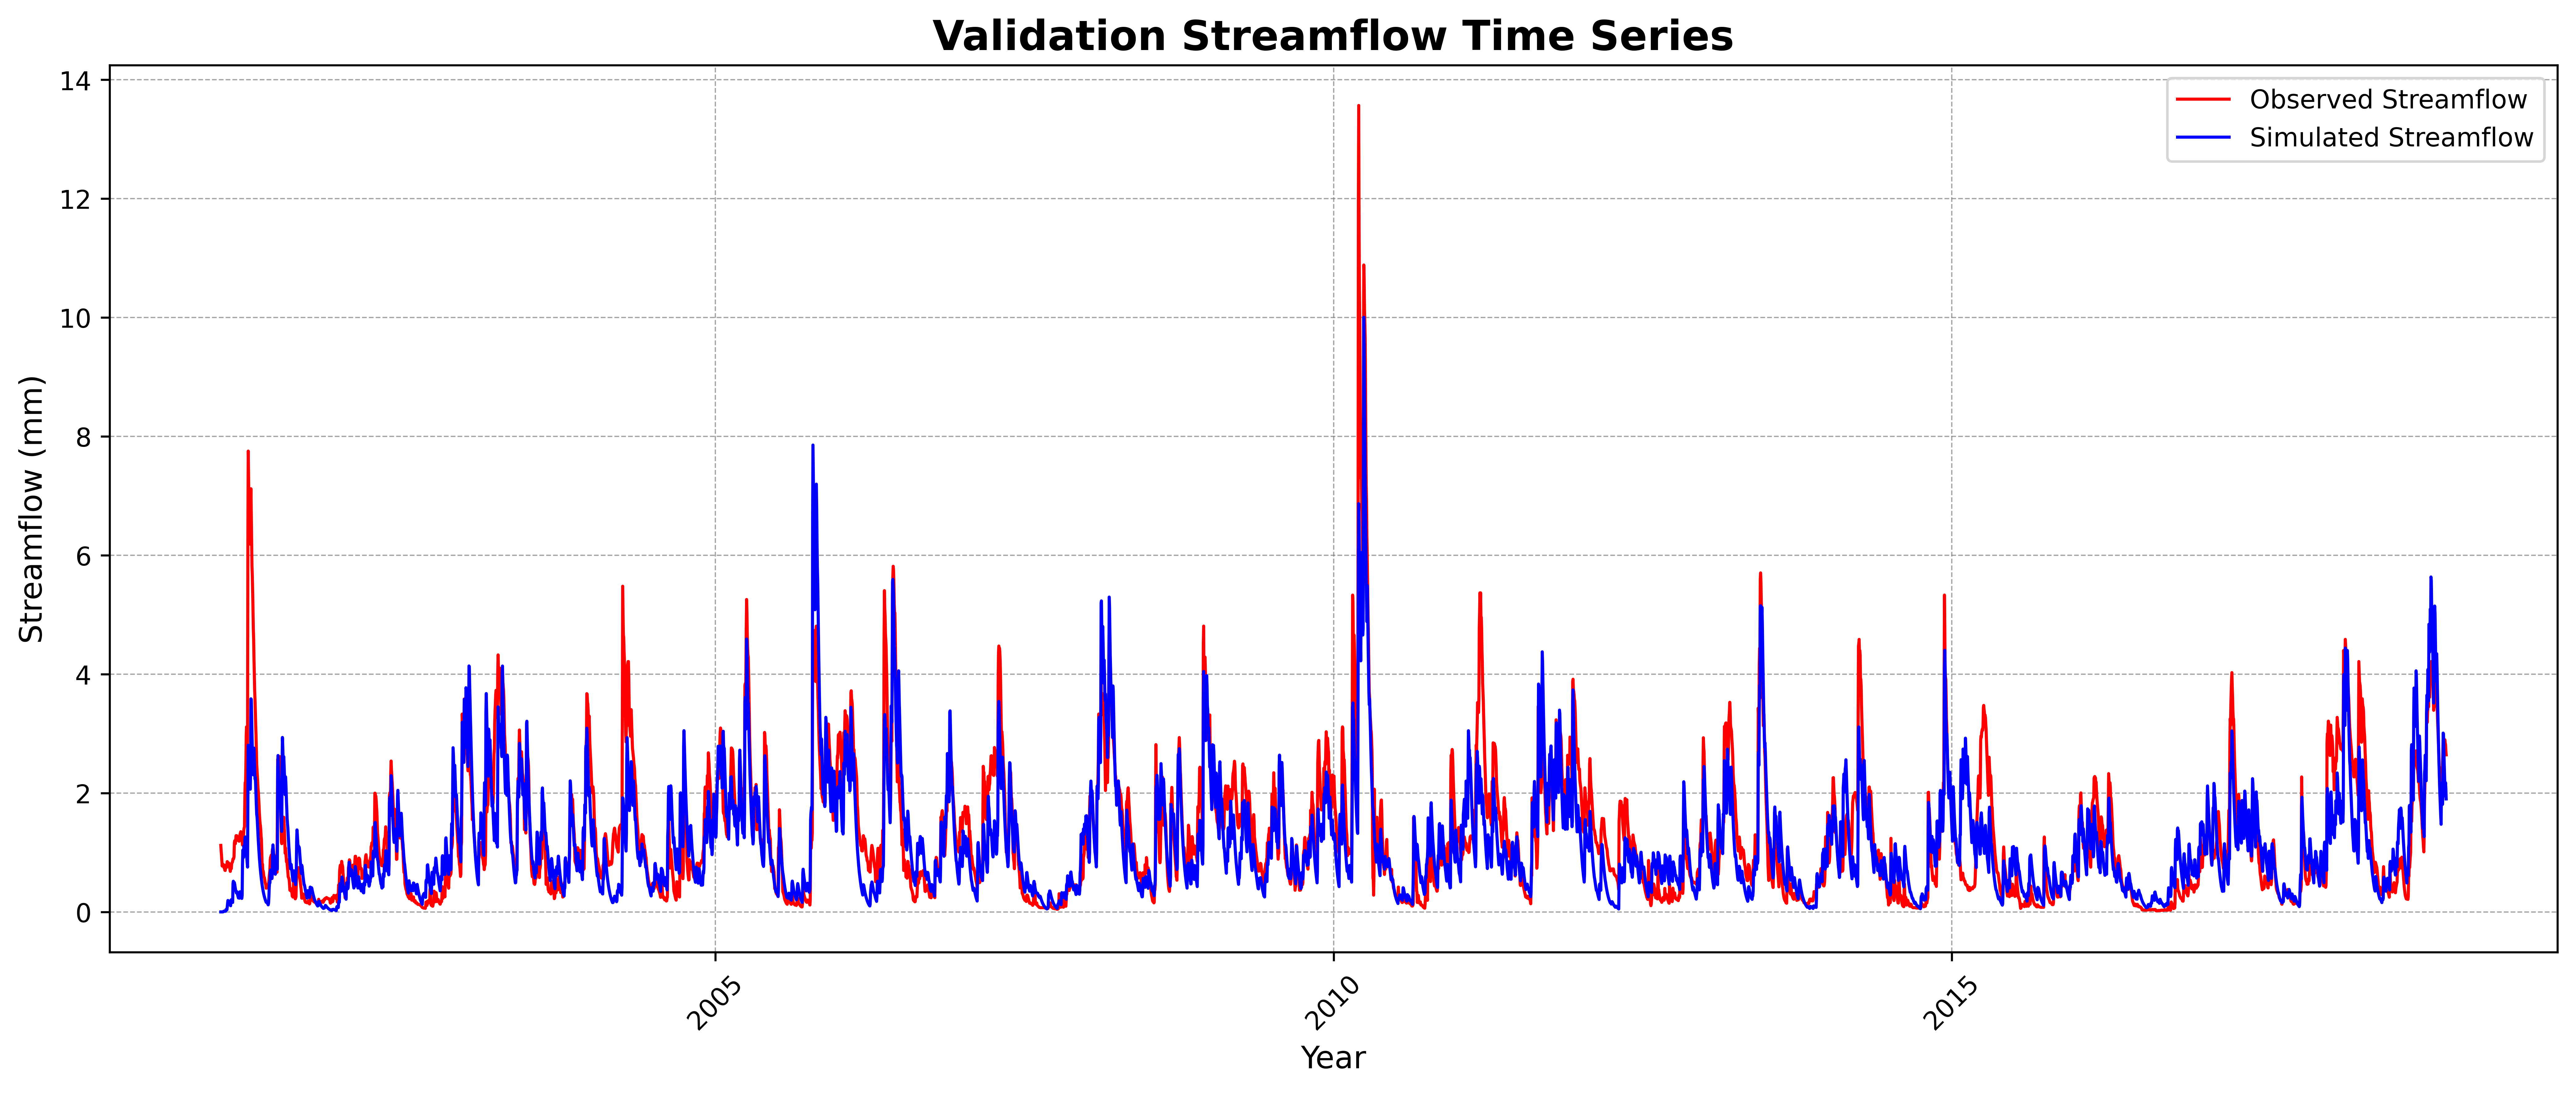

In [22]:

# Plot validation streamflow timeseries

fig, ax = plt.subplots(figsize=(14, 6), dpi=600)
ax.plot(df_val.index, df_val['streamflow_mm'], color='Red', linewidth=1.2, label='Observed Streamflow')
ax.plot(df_val.index, df_val['Q_val'], color='blue', linewidth=1.2, label='Simulated Streamflow')

# Beautify x-axis: 5-year interval
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=10)

# Improve style
ax.set_title("Validation Streamflow Time Series", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Streamflow (mm)", fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
#ax.spines[['top', 'right']].set_visible(False)  # Cleaner border
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/validation_streamflow_Time_Series_charles.png', dpi=600, bbox_inches='tight')
plt.show()
